# KAZ env  

## 1 DQN pour tous

Using cpu device


/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 2.18GB > 1.84GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    exploration_rate | 0.194    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1720     |
|    time_elapsed     | 0        |
|    total_timesteps  | 848      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00599  |
|    n_updates        | 46       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1778     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1584     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00188  |
|    n_updates        | 92       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rat

/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/supersuit/vector/sb3_vector_wrapper.py:52: UserWarning: PettingZoo environments do not take the `render(mode)` argument, to change rendering mode, re-initialize the environment using the `render_mode` argument.
  warnings.warn(
/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/pettingzoo/butterfly/knights_archers_zombies/knights_archers_zombies.py:799: UserWarning: WARN: You are calling render method without specifying any render mode.
  gymnasium.logger.warn(


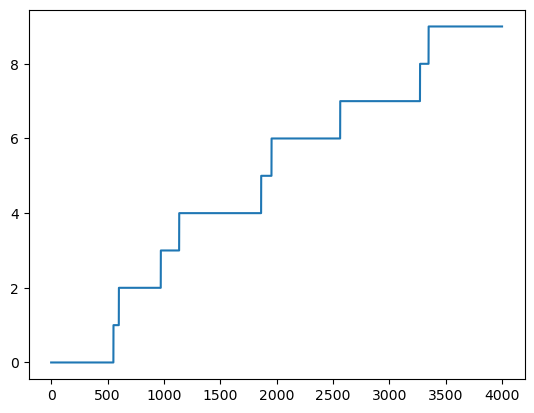

In [18]:
from pettingzoo.butterfly import knights_archers_zombies_v10
from pettingzoo.utils.conversions import aec_to_parallel
import supersuit as ss
from stable_baselines3 import DQN
import numpy as np
import matplotlib.pyplot as plt

# Charger l'environnement PettingZoo AEC (par défaut)
aec_env = knights_archers_zombies_v10.env()

# Convertir l'environnement AEC en ParallelEnv
parallel_env = aec_to_parallel(aec_env)

# Appliquer le wrapper 'black_death_v3' pour gérer les agents inactifs
parallel_env = ss.black_death_v3(parallel_env)

# Utiliser SuperSuit pour convertir l'environnement en un environnement Gym compatible
gym_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
gym_env = ss.concat_vec_envs_v1(gym_env, 1, base_class='stable_baselines3')

# Initialiser le modèle DQN
model = DQN('MlpPolicy', gym_env, verbose=1)

# Entraîner l'agent
model.learn(total_timesteps=10000)

# Sauvegarder le modèle
model.save("dqn_knights_archers_zombies")

# Charger le modèle pour l'utiliser ou l'évaluer
model = DQN.load("dqn_knights_archers_zombies")

# Évaluer le modèle
env = knights_archers_zombies_v10.parallel_env()
env = ss.black_death_v3(env)
env = ss.pettingzoo_env_to_vec_env_v1(env)
env = ss.concat_vec_envs_v1(env, 1, base_class='stable_baselines3')
model.set_env(env)

obs = env.reset()
rewards = []
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    rewards.append(reward)
    if done.any():
        obs = env.reset()

# Afficher les récompenses
plt.plot(np.cumsum(rewards))
plt.show()

# # Make a video of the trained model
# env = knights_archers_zombies_v10.parallel_env()
# env = ss.black_death_v3(env)
# env = ss.pettingzoo_env_to_vec_env_v1(env)
# env = ss.concat_vec_envs_v1(env, 1, base_class='stable_baselines3')
# model.set_env(env)
# ss.record_video(env, model, "dqn_knights_archers_zombies.mp4", video_length=1000, fps=10)

# # Afficher la vidéo


## 4 DQN indep

In [1]:
from pettingzoo.butterfly import knights_archers_zombies_v10
from pettingzoo.utils.conversions import aec_to_parallel
import supersuit as ss
from stable_baselines3 import DQN
import numpy as np
import matplotlib.pyplot as plt
import time 
# Charger l'environnement PettingZoo AEC (par défaut)
aec_env = knights_archers_zombies_v10.env()

# Convertir l'environnement AEC en ParallelEnv
parallel_env = aec_to_parallel(aec_env)

# Appliquer le wrapper 'black_death_v3' pour gérer les agents inactifs
parallel_env = ss.black_death_v3(parallel_env)

# Utiliser SuperSuit pour convertir l'environnement en un environnement Gym compatible
gym_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
gym_env = ss.concat_vec_envs_v1(gym_env, 1, base_class='stable_baselines3')

# Initialiser les modèles DQN pour chaque agent
num_agents = gym_env.num_envs  # Récupérer le nombre d'agents à partir de l'environnement
models_archer = [DQN(  
                'MlpPolicy', 
                gym_env, 
                verbose=0,
                learning_rate=0.001,
                buffer_size=10000,
                batch_size=64,
                learning_starts=200,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=100,
                exploration_fraction=0.3,
                exploration_initial_eps=0.05,
                exploration_final_eps=0.03,
                gamma=0.96

            ) for _ in range(2)]

models_knight = [DQN(  
                'MlpPolicy', 
                gym_env, 
                verbose=0,
                learning_rate=0.001,
                buffer_size=10000,
                batch_size=64,
                learning_starts=200,
                train_freq=1,
                gradient_steps=1,
                target_update_interval=100,
                exploration_fraction=0.3,
                exploration_initial_eps=0.05,
                exploration_final_eps=0.03,
                gamma=0.96
            ) for _ in range(2)]

models = models_archer + models_knight

### TODO TRAIN AGENT INDENPENDENTLY FIRST THEN TRAIN THEM TOGETHER

start_t = time.time()

# Entraîner les agents
timesteps = 10_000
nb_episodes = 20
for episode in range(nb_episodes):  # Nombre d'épisodes d'entraînement
    t = time.time() - start_t
    hours, remainder = divmod(t, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f"Episode {episode + 1} - Temps écoulé: {int(hours):02}:{int(minutes):02}:{int(seconds):02} s")
    obs = gym_env.reset()
    done = np.array([False] * num_agents)

    for step in range(timesteps):
        if step % 1000 == 0:
            print(f"Step {step}/{timesteps}")
        actions = np.array([models[i].predict(obs[i])[0] for i in range(num_agents)])  # Prédire les actions pour chaque agent
        obs, rewards_batch, done, _ = gym_env.step(actions)  # Appliquer les actions dans l'environnement
        
        for i in range(num_agents):
            models[i].learn(total_timesteps=1)  # Mettre à jour chaque agent après chaque étape
        
        if done.all():
            obs = gym_env.reset()
            done = np.array([False] * num_agents)

    for i in range(num_agents):
        models[i].learn(total_timesteps=100)

    # Sauvegarder les modèles
    for i in range(num_agents):
        models[i].save(f"./checkpoints/dqn_agent_{i + 1}_knights_archers_zombies_{episode}")

# Sauvegarder les modèles
for i in range(num_agents):
    models[i].save(f"dqn_agent_{i + 1}_knights_archers_zombies")

print("Entraînement terminé !")

Episode 1 - Temps écoulé: 00:00:00 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000


/Users/angeleramauge/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'checkpoints' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Episode 2 - Temps écoulé: 00:02:18 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 3 - Temps écoulé: 00:04:38 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 4 - Temps écoulé: 00:06:57 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 5 - Temps écoulé: 00:09:17 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 6 - Temps écoulé: 00:11:37 s
Step 0/10000
Step 1000/10000
Step 2000/10000
Step 3000/10000
Step 4000/10000
Step 5000/10000
Step 6000/10000
Step 7000/10000
Step 8000/10000
Step 9000/10000
Episode 7 - Temps écoulé: 00:1

## MADDQN

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from pettingzoo.butterfly import knights_archers_zombies_v10

# Configuration du réseau Q pour chaque agent
class QNetwork(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Fonction de sélection d'action avec epsilon-greedy
def select_action(state, q_net, epsilon, action_dim):
    if random.random() < epsilon:
        action = random.randint(0, action_dim - 1)
    else:
        with torch.no_grad():
            #print("state,",state)
           # state = state.flatten()
            q_values = q_net(torch.FloatTensor(state.T))
            action = torch.argmax(q_values,dim=1).item()
    
    # Assurez-vous que l'action est valide
    assert 0 <= action < action_dim, f"Action {action} hors limites [0, {action_dim - 1}]"
    return action

# Buffer de replay pour stocker les expériences de chaque agent
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Initialisation de l'environnement et de chaque agent
env = knights_archers_zombies_v10.env()
env.reset()
agents = env.agents  # Obtenir la liste des agents après reset
num_agents = len(agents)
state_dims = env.observation_space(agents[0]).shape[0]
action_dims = env.action_space(agents[0]).n

# Hyperparamètres
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.1
gamma = 0.95
lr = 0.001
batch_size = 64
target_update_freq = 100
buffer_capacity = 10000
num_episodes = 100  # Augmentez le nombre d'épisodes pour un meilleur entraînement

# Initialisation des réseaux Q et des buffers pour chaque agent
q_networks = {agent: QNetwork(state_dims, action_dims) for agent in agents}
target_networks = {agent: QNetwork(state_dims, action_dims) for agent in agents}
optimizers = {agent: optim.Adam(q_networks[agent].parameters(), lr=lr) for agent in agents}
buffers = {agent: ReplayBuffer(buffer_capacity) for agent in agents}

# Synchronisation initiale des réseaux cibles
for agent in agents:
    target_networks[agent].load_state_dict(q_networks[agent].state_dict())

# Boucle d'entraînement
for episode in range(num_episodes):
    env.reset()
    state = {agent: env.observe(agent) for agent in agents}  # Initialiser l'état pour chaque agent
    done = {agent: False for agent in agents}
    episode_reward = {agent: 0 for agent in agents}

    while not all(done.values()):
        actions = {}
        
        # Sélection d'actions pour chaque agent
        for agent in agents:
            if not done[agent]:
                action = select_action(state[agent], q_networks[agent], epsilon, action_dims)
                
                # Vérification de l'action
                assert 0 <= action < action_dims, f"Action {action} pour {agent} n'est pas dans l'espace d'actions [0, {action_dims - 1}]"
                actions[agent] = action
                print(f"Agent {agent} a choisi l'action {action}")

        # Environnement procède aux actions
        try:
            next_state, rewards, dones, _ = env.step(actions)
        except AssertionError as e:
            print(f"Erreur lors du passage d'actions à l'environnement: {e}")
            break  # Sortir de la boucle si une erreur se produit

        # Enregistrement de chaque expérience dans le buffer
        for agent in agents:
            if not done[agent]:
                buffers[agent].push(state[agent], actions[agent], rewards[agent], next_state[agent], dones[agent])
                episode_reward[agent] += rewards[agent]

            # Mise à jour des états et terminaux
            done[agent] = dones[agent]
        
        # Mise à jour des états pour le prochain pas de temps
        for agent in agents:
            if not done[agent]:
                state[agent] = next_state[agent]  # Mettre à jour l'état pour chaque agent

        # Apprentissage pour chaque agent
        for agent in agents:
            if len(buffers[agent]) >= batch_size and not done[agent]:
                # Extraction d'un mini-lot d'expériences
                batch = buffers[agent].sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Conversion des expériences en tenseurs
                states = torch.FloatTensor(states)
                actions = torch.LongTensor(actions).unsqueeze(1)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(next_states)
                dones = torch.FloatTensor(dones)

                # Calcul des valeurs Q cibles
                current_q_values = q_networks[agent](states).gather(1, actions).squeeze()
                with torch.no_grad():
                    max_next_q_values = target_networks[agent](next_states).max(1)[0]
                    target_q_values = rewards + (gamma * max_next_q_values * (1 - dones))

                # Calcul de la perte et rétropropagation
                loss = nn.MSELoss()(current_q_values, target_q_values)
                optimizers[agent].zero_grad()
                loss.backward()
                optimizers[agent].step()

        # Mise à jour des réseaux cibles
        if episode % target_update_freq == 0:
            for agent in agents:
                target_networks[agent].load_state_dict(q_networks[agent].state_dict())

    # Décroissance de epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    print(f"Episode {episode + 1}/{num_episodes} - Rewards: {episode_reward}")

print("Entraînement terminé!")


Agent archer_0 a choisi l'action 0
Agent archer_1 a choisi l'action 3
Agent knight_0 a choisi l'action 1
Agent knight_1 a choisi l'action 2
Erreur lors du passage d'actions à l'environnement: action is not in action space
Episode 1/100 - Rewards: {'archer_0': 0, 'archer_1': 0, 'knight_0': 0, 'knight_1': 0}
Agent archer_0 a choisi l'action 2
Agent archer_1 a choisi l'action 0
Agent knight_0 a choisi l'action 5
Agent knight_1 a choisi l'action 0
Erreur lors du passage d'actions à l'environnement: action is not in action space
Episode 2/100 - Rewards: {'archer_0': 0, 'archer_1': 0, 'knight_0': 0, 'knight_1': 0}
Agent archer_0 a choisi l'action 3
Agent archer_1 a choisi l'action 1
Agent knight_0 a choisi l'action 1
Agent knight_1 a choisi l'action 4
Erreur lors du passage d'actions à l'environnement: action is not in action space
Episode 3/100 - Rewards: {'archer_0': 0, 'archer_1': 0, 'knight_0': 0, 'knight_1': 0}
Agent archer_0 a choisi l'action 0
Agent archer_1 a choisi l'action 3
Agent 

RuntimeError: a Tensor with 5 elements cannot be converted to Scalar